In [ ]:
!pip install yellowbrick

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
import pandas_profiling as pp

%matplotlib inline

In [2]:
def apply_cluster(df, k = 2, eps_ = 0.5, min_samples_ = 25, kmeans = False, gaussian_mixture = False, hier = False):
    '''
    Function thats apply different number of clustring algo with defualt algo: DBscan
    '''
    if hier:
        model = AgglomerativeClustering(n_clusters = k).fit(df)
    elif kmeans:
        model = KMeans(n_clusters= k).fit(df)
    elif gaussian_mixture:
        return GaussianMixture(n_components=k).fit(df).predict(df)
    else:
        model = DBSCAN(eps = eps_, min_samples = min_samples_).fit(df)
    return model.labels_

In [3]:
def apply_no_noise(df, labels):
    '''
    returns the data with no noise
    '''
    df['out'] = labels
    return df[df['out'] != -1]

In [4]:
df = pd.read_csv('Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [5]:
df_copy = df.copy()

In [6]:
df_copy.drop(['label'], axis=1, inplace=True)

# PCA

In [7]:
#apply pca
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_copy)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.4012914 , 0.74399716, 0.90161881, 0.96778222, 0.99724529,
       0.99993372, 1.        ])

In [8]:
best_dim = np.argmax(cumsum >= 0.95) + 1
best_dim

4

In [9]:
pcaa = PCA(n_components = best_dim)
pcaa.fit(df_copy)
df_copy = pcaa.transform(df_copy)
#list to dataframe
df_copy = pd.DataFrame(df_copy)
df_copy

,0,1,2,3
0,-59.969729,84.055388,32.450240,1.031939
1,-64.090628,107.779037,24.381552,11.177477
2,-75.156888,142.468675,-0.556024,1.930587
3,-80.247626,117.340628,13.940485,-3.881560
4,-85.084925,137.343003,16.712434,0.478325
...,...,...,...,...
2195,-64.055404,54.019513,44.868290,14.166060
2196,-52.816986,3.172884,38.516656,8.100532
2197,-65.984590,48.821451,55.387287,16.311582
2198,-42.988902,7.978078,55.117203,24.208316


In [10]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2200 non-null   float64
 1   1       2200 non-null   float64
 2   2       2200 non-null   float64
 3   3       2200 non-null   float64
dtypes: float64(4)
memory usage: 68.9 KB


In [11]:
pp.ProfileReport(df_copy)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Kmeans

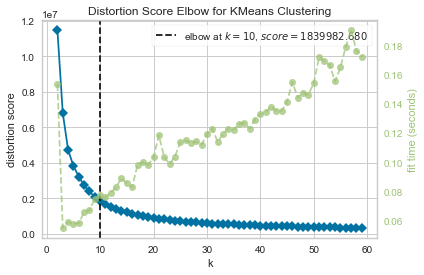

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,60))

visualizer.fit(df_copy)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [13]:
labels = apply_cluster(df_copy, k = 10, kmeans = True)

In [14]:
silhouette_score(df_copy, labels)

0.4552843466368396

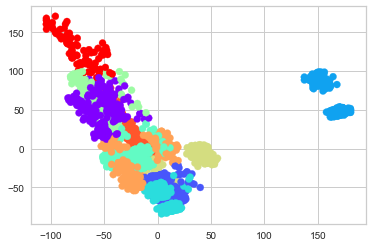

In [15]:
plt.scatter(df_copy['0'], df_copy['1'], c=labels, cmap='rainbow')

# Hierarchical

In [16]:
scores = []
for i in range(2, 20):
    labels = apply_cluster(df_copy, k = i, hier = True)
    scores.append(silhouette_score(df_copy, labels))
best , num_of_clusters = max(scores), scores.index(max(scores))+ 2
print(best, num_of_clusters)

0.559813459750465 2


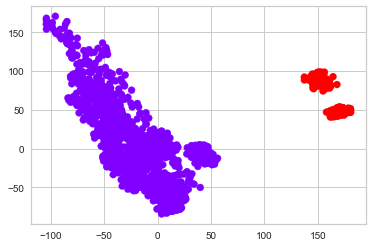

In [17]:
plt.scatter(df_copy['0'], df_copy['1'], c=apply_cluster(df_copy, k = 2, hier = True), cmap='rainbow')

# Gaussian Mixture

In [18]:
scores = []
for i in range(2, 60):
    labels = apply_cluster(df_copy, k = i, gaussian_mixture = True)
    scores.append(silhouette_score(df_copy, labels))
best , num_of_clusters = max(scores), scores.index(max(scores))+ 2
print(best, num_of_clusters)

0.559813459750465 2


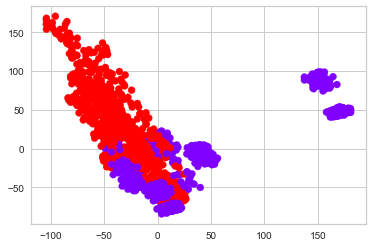

In [19]:
plt.scatter(df_copy['0'], df_copy['1'], c=apply_cluster(df_copy, k = num_of_clusters, gaussian_mixture = True), cmap='rainbow')

# DBscan

In [20]:
labels = apply_cluster(df_copy, eps_= 15, min_samples_ = 3)
silhouette_score(df_copy, labels)

0.2625758998642557

In [21]:
len(set(labels))

12

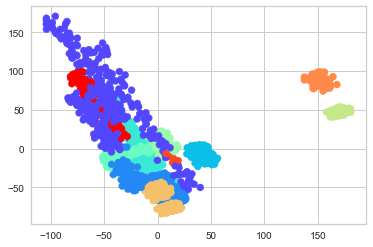

In [22]:
plt.scatter(df_copy['0'], df_copy['1'], c= apply_cluster(df_copy, eps_= 15, min_samples_ = 3), cmap='rainbow')

DBscan with no noise

In [23]:
labels = apply_cluster(df_copy, eps_= 15, min_samples_ = 3)
len([i for i in labels if i == -1])

3

In [24]:
data_no_noise = apply_no_noise(df_copy, labels)
labels = apply_cluster(data_no_noise, eps_= 15, min_samples_ = 3)
silhouette_score(data_no_noise, labels)

0.284782070949909

In [25]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

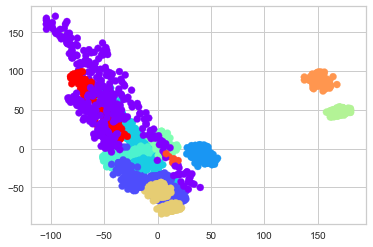

In [26]:
plt.scatter(data_no_noise['0'], data_no_noise['1'], c= apply_cluster(data_no_noise, eps_= 15, min_samples_ = 3), cmap='rainbow')

# Dendrogram

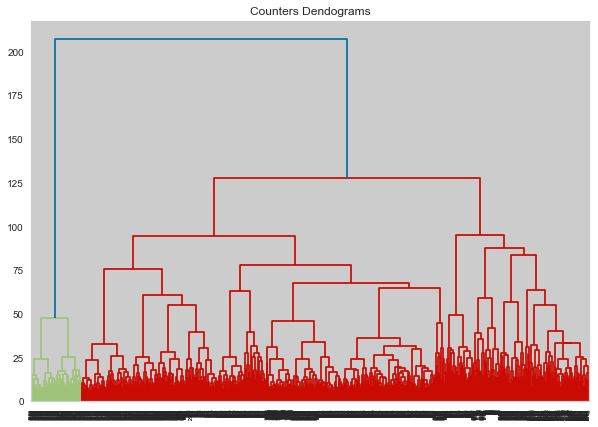

In [27]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Counters Dendograms")
dend = shc.dendrogram(shc.linkage(y = df_copy , method='average',metric='euclidean')) #fill y with your dataframe
                                                                                      #and method with linkage criteria
                                                                                      #and metric with distance function